# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [ ]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

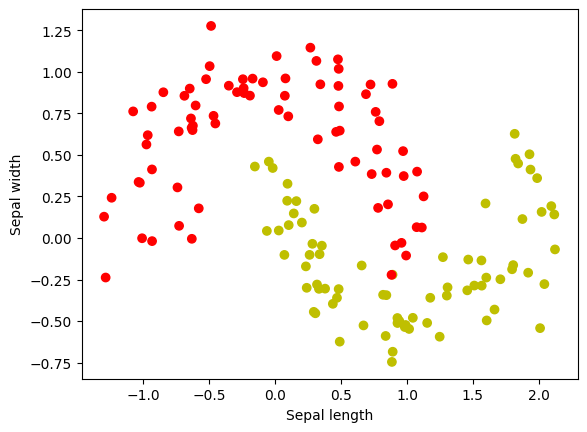

In [ ]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [ ]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
#            nn.Sigmoid(),
            nn.Linear(5, 5),
#            nn.Sigmoid(),
            nn.Linear(5,3),
        )

#class Modelo(nn.Module):
#    def __init__(self):
#        super(Modelo, self).__init__()
#        self.dense = nn.Sequential(
#            nn.Linear(2, 10), # Camada de entrada para 10 neurônios
#            nn.ReLU(),
#            nn.Linear(10, 3) # Camada de 10 neurônios para a saída (3 classes)
#        )
#class Modelo(nn.Module):
#    def __init__(self):
#       super(Modelo, self).__init__()
#       self.dense = nn.Sequential(
#            nn.Linear(2, 5),   # Camada 1
#            nn.Sigmoid(),
#            nn.Linear(5, 5),   # Camada 2
#            nn.Sigmoid(),
#            nn.Linear(5, 5),   # Camada 3 (nova)
#            nn.Sigmoid(),
#            nn.Linear(5, 3)    # Camada de saída
#        )
#class Modelo(nn.Module):
#    def __init__(self):
#        super(Modelo, self).__init__()
#       self.dense = nn.Sequential(
#            nn.Linear(2, 2), # Camada de entrada para 2 neurônios
#            nn.Sigmoid(),
#           nn.Linear(2, 3)  # Camada de 2 neurônios para a saída (3 classes)
#        )
    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [ ]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [ ]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [ ]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.2877)


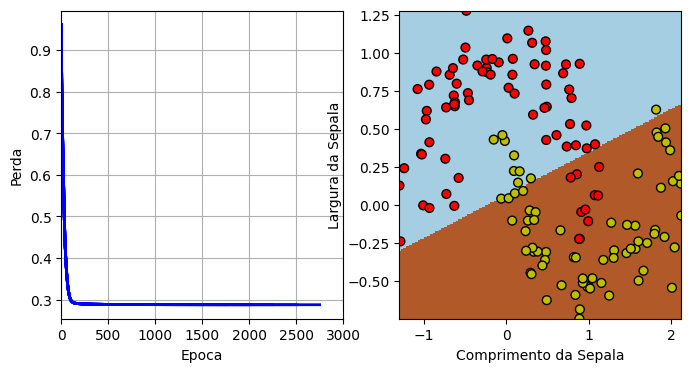

In [ ]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [ ]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[-0.9536,  0.2710],
        [ 0.4062,  0.9617],
        [ 0.6023, -0.8981],
        [ 0.1986,  0.4203],
        [-0.2776, -0.6002]])
dense.0.bias    torch.Size([5])
tensor([ 0.3953,  0.2358, -0.3069,  1.0191, -0.3954])
dense.1.weight  torch.Size([5, 5])
tensor([[-0.4828, -0.7361,  0.7223, -0.4284,  0.2841],
        [ 0.1601,  0.6403, -0.2724,  0.6640, -0.3061],
        [-0.2809, -0.4016,  0.1923,  0.1249, -0.2338],
        [ 0.0084,  0.2483,  0.4431,  0.8424,  0.2222],
        [ 0.3116,  0.4835, -0.2056,  0.1243, -0.4732]])
dense.1.bias    torch.Size([5])
tensor([0.2973, 0.3036, 0.5882, 1.1675, 0.8653])
dense.2.weight  torch.Size([3, 5])
tensor([[-0.9073,  0.5593, -0.2638,  0.0335,  0.7077],
        [ 0.7677, -0.1866,  0.6196,  0.9827,  0.4052],
        [ 0.3164, -0.8165, -0.3099, -0.9391, -0.7593]])
dense.2.bias    torch.Size([3])
tensor([ 0.2634,  1.2267, -0.4708])


### Avaliação do classificador

In [ ]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.88


### Matriz de confusão

In [ ]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,66,9
1,9,66


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões. R.: Uma rede com uma única camada oculta, mas com um número suficiente de neurônios (sendo "larga"), demonstrou ser capaz de aprender a fronteira de decisão complexa do dataset "meia-luas". A rede mais profunda conseguiu aprender a separação não-linear do dataset "meia-luas" com alta precisão nos dados de treino, embora tenha mostrado alguma instabilidade no início do processo de otimização.  A rede com apenas uma camada oculta de dois neurônios é inadequada para o dataset "meia-luas". Ela resulta em uma alta perda de treinamento e uma fronteira de decisão que não consegue separar as classes corretamente.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva. R.: Em resumo, empilhar múltiplas camadas Sigmoid em uma rede profunda não conseguiu separar bem as "meias-luas" e a perda demora para se estabilizar.
3. O que ocorre quando não se utiliza ativação não linear entre camadas? R.: A rede se comporta como um modelo linear simples, criando uma fronteira de decisão que é uma linha reta. A perda estabiliza em um valor alto (em torno de 0.3 na imagem), indicando que o modelo não se ajustou bem aos dados.

## Principais aprendizados